<a href="https://colab.research.google.com/github/cjkreienkamp/wpolo-scoresheet-ocr/blob/main/wpolo_scoresheet_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Configure Environment

### 0.1 Imports

In [1]:
!apt-get install poppler-utils 1> /dev/null
!pip install torch torchvision torchaudio 1> /dev/null

In [2]:
try:
    import pdf2image
except:
    !pip install pdf2image 1> /dev/null
    import pdf2image

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
from imutils import contours
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from typing import List
import tabulate

### 0.2 Create folder structure

In [3]:
if not os.path.exists('input'): os.symlink('/content/drive/MyDrive/input', 'input')
if not os.path.exists('output/aligned'): os.makedirs('output/aligned')
if not os.path.exists('output/TIME'): os.makedirs('output/TIME')
if not os.path.exists('output/TIME_processed'): os.makedirs('output/TIME_processed')
if not os.path.exists('output/CAP'): os.makedirs('output/CAP')
if not os.path.exists('output/CAP_processed'): os.makedirs('output/CAP_processed')
if not os.path.exists('output/TEAM'): os.makedirs('output/TEAM')
if not os.path.exists('output/REMARKS'): os.makedirs('output/REMARKS')
if not os.path.exists('output/SCORE'): os.makedirs('output/SCORE')
if not os.path.exists('output/SCORE_processed'): os.makedirs('output/SCORE_processed')

### 0.3 Load classification models

In [ ]:
mnist_model = torch.jit.load('/content/drive/MyDrive/input/models/mnist_model.pt', map_location=torch.device('cpu'))
team_model = torch.jit.load('/content/drive/MyDrive/input/models/team_model.pt', map_location=torch.device('cpu'))
remarks_model = torch.jit.load('/content/drive/MyDrive/input/models/remarks_model.pt',  map_location=torch.device('cpu'))

## 1. Input

In [ ]:
SCORESHEET = 4
NUMBER_OF_ROWS = 14

png = f'scoresheet{SCORESHEET}.png'
if png not in os.listdir('input/scoresheet_pngs'):
    print(f'[ERROR] input/scoresheet_pngs/scoresheet{SCORESHEET}.png does not exist')
if not png[:-4]+'.txt' in os.listdir('input/gamelog_corner_pts'):
    print(f'[ERROR] input/gamelog_corner_pts/scoresheet{SCORESHEET}.txt does not exist')

## 2. Load and parse cells on scoresheet

### 1.3 Identify, straighten, and save the gamelogs from the scoresheet

In [ ]:
gamelog_height = 500
gamelog_width = 369
gamelog_template_corners = np.array([[0,0], [gamelog_width,0], [0,gamelog_height], [gamelog_width,gamelog_height]])

png = f'scoresheet{SCORESHEET}.png'
scoresheet = cv2.imread('input/scoresheet_pngs/'+png)

with open('input/gamelog_corner_pts/'+png[:-4]+'.txt', 'r') as f:
    data = f.read().split('\n')
    for i in range(5):
        gamelog_corners = np.array([[float(data[i*8+0]), float(data[i*8+1])],
                                    [float(data[i*8+2]), float(data[i*8+3])],
                                    [float(data[i*8+4]), float(data[i*8+5])],
                                    [float(data[i*8+6]), float(data[i*8+7])]])
        (H, mask) = cv2.findHomography(gamelog_corners, gamelog_template_corners, method=cv2.RANSAC)
        aligned = cv2.warpPerspective(scoresheet, H, (gamelog_width, gamelog_height))
        cv2.imwrite('output/aligned/'+png[5:-4]+'_log'+str(i+1)+'.png',aligned)

### 1.4 Draw lines between every cell on the gamelog

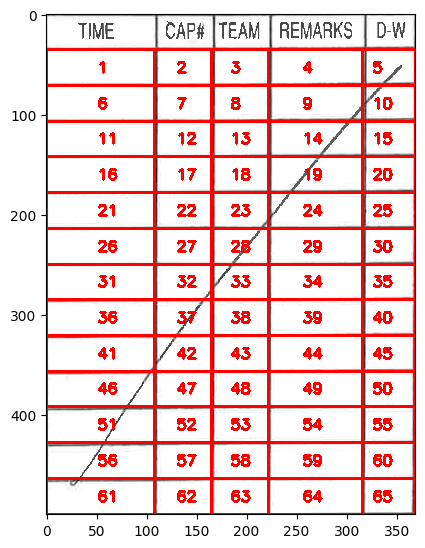

In [ ]:
COLUMN_NUMBERS = [1, 2, 3, 4, 0]
column_x_values = [0,108,165,222,316,gamelog_width]
gamelog_bb_cell = cv2.imread(f'output/aligned/sheet{SCORESHEET}_log5.png')

row_y_values = [int(gamelog_height/NUMBER_OF_ROWS*(i+1)) for i in range(NUMBER_OF_ROWS)]
n_cell = 0
for y1 in row_y_values[:-1]:
    for x1 in column_x_values[:-1]:
        n_cell += 1
        x2 = column_x_values[column_x_values.index(x1)+1]
        y2 = row_y_values[row_y_values.index(y1)+1]
        cv2.rectangle(gamelog_bb_cell, (x1, y1), (x2, y2), (255,0,0), 2)
        if n_cell%5 in COLUMN_NUMBERS:
            cv2.putText(gamelog_bb_cell, str(n_cell), (int((x1+x2)/2.1), int((y1+y2)/2+5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

plt.figure(figsize=(5,5))
plt.imshow(gamelog_bb_cell)
plt.subplots_adjust(top=1, bottom=0, left=-0.3, right=1.3)
plt.show()

## 3. Save Data

### 2.1 Save every desired cell as its own image

In [ ]:
!rm -r /content/output/TIME; rm -r /content/output/CAP; rm -r /content/output/REMARKS; rm -r /content/output/TEAM; rm -r /content/output/SCORE
!mkdir /content/output/TIME; mkdir /content/output/CAP; mkdir /content/output/REMARKS; mkdir /content/output/TEAM; mkdir /content/output/SCORE

In [ ]:
for png in os.listdir('output/aligned'):
    image = cv2.imread('output/aligned/'+png)
    n_cell = 0
    for y1 in row_y_values[:-1]:
        for x1 in column_x_values[:-1]:
            n_cell += 1
            if n_cell%5 in COLUMN_NUMBERS:
                x2 = column_x_values[column_x_values.index(x1)+1]
                y2 = row_y_values[row_y_values.index(y1)+1]
                row_number = (int(png[-5])-1)*(NUMBER_OF_ROWS-1) + n_cell//5 + 1
                if n_cell%5 == 1:
                    column_name = 'TIME'
                    cell = image[y1:y2, x1:x2]
                if n_cell%5 == 2:
                    column_name = 'CAP'
                    cell = image[y1+2:y2-3, x1+8:x2-8]
                if n_cell%5 == 3:
                    column_name = 'TEAM'
                    cell = image[y1:y2, x1:x2]
                if n_cell%5 == 4:
                    column_name = 'REMARKS'
                    cell = image[y1:y2, x1:x2]
                if n_cell%5 == 0:
                    column_name = 'SCORE'
                    cell = image[y1:y2-3, x1+3:x2-3]
                    row_number -= 1
                cv2.imwrite(f'output/{column_name}/sheet{png[5:-9]}_row{row_number}.png',cell)

## 4. Output

### 4.0 Functions

In [ ]:
def process_cap_cell(image_path):
    raw = cv2.imread(image_path)
    grayscale = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    cv2.rectangle(grayscale, (0,0), (raw.shape[1], raw.shape[0]), (240,240,240), 2)
    binary = cv2.threshold(grayscale, 230, 255, cv2.THRESH_BINARY_INV)[1]
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    out = cv2.dilate(binary, element, iterations=2)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1)) # want to connect horizontally at the top
    out[0:2, 0:out.shape[1]] = cv2.dilate(out[0:2, 0:out.shape[1]], element, iterations=2)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1)) # want to connect horizontally at the bottom
    out[out.shape[0]-2:out.shape[0], 0:out.shape[1]] = cv2.dilate(out[out.shape[0]-2:out.shape[0], 0:out.shape[1]], element, iterations=2)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    out = cv2.erode(out, element)
    cnts = cv2.findContours(out.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    new_paths = []
    if len(cnts):
        cnts = contours.sort_contours(cnts, method="left-to-right")[0]
        for (i, cnt) in enumerate(cnts):
            (x, y, w, h) = cv2.boundingRect(cnt)
            if w*h > 50 and y < 15 and y+h > 15 and h > 10:
                digit = out[y:y + h, x:x + w]
                digit = cv2.resize(digit, (int(18/h*w), 18))
                ypad = 5
                xpad = max(0, int((28-int(18/h*w))/2))
                digit = cv2.copyMakeBorder(digit,top=ypad,bottom=ypad,left=xpad,right=xpad,borderType=cv2.BORDER_CONSTANT,value=[0,0,0])
                png = image_path.split('/')[-1][:-4]
                column_name = image_path.split('/')[-2]
                new_path = f'/content/output/{column_name}_processed/{png}_cnt{i}.png'
                cv2.imwrite(new_path,digit)
                new_paths.append(new_path)
    return new_paths



def predict_cell(   model: torch.nn.Module,
                    image_path: str,
                    class_names: List[str] = None,
                    train_dim=(28,28)):

    transform = transforms.Compose([
            transforms.Lambda((lambda x: x[:3])),
            transforms.Resize(train_dim),
            transforms.Grayscale(num_output_channels=1)
    ])

    image = torchvision.io.read_image(image_path).type(torch.float32)
    image = image / 255.
    image = transform(image)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    with torch.inference_mode():
        image = image.unsqueeze(dim=0) # add an extra dimension to image
        image_pred = model(image.to(device))

    image_pred_probs = torch.softmax(image_pred, dim=1) # convert logits --> prediction probabilities
    image_pred_label = torch.argmax(image_pred_probs, dim=1) # convert prediction probabilities --> prediction labels

    if class_names:
        prediction = class_names[image_pred_label.cpu()]
        probability = image_pred_probs.max().cpu()
        return prediction
    else:
        prediction = image_pred_label.cpu()
        probability = image_pred_probs.max().cpu()
        return prediction

### 4.1 Create table

In [ ]:
!rm -r output/TIME_processed; rm -r output/CAP_processed; rm -r output/SCORE_processed
!mkdir output/TIME_processed; mkdir output/CAP_processed; mkdir output/SCORE_processed

In [ ]:
dark_score = [0,0,0,0,0]
white_score = [0,0,0,0,0]
quarter = 1

table = [['ROW','TIME','CAP','TEAM','REMARKS','SCORE']]
for row in range(65):
    cell = f'sheet{SCORESHEET}_row{row+1}.png'

    team = predict_cell(model=team_model,
                        image_path=f'/content/output/TEAM/{cell}',
                        class_names=['D', 'W', '-----'],
                        train_dim=(28,28))

    remarks = predict_cell(model=remarks_model,
                        image_path=f'/content/output/REMARKS/{cell}',
                        class_names=['C-card', 'E-ejection', 'G-goal', 'P-penalty', 'TO-timeout', '-----'],
                        train_dim=(28,73))

    time_digit_paths = process_cap_cell(f'/content/output/TIME/{cell}')
    time = ''
    for digit_path in time_digit_paths:
        digit = predict_cell(model=mnist_model,
                            image_path=digit_path,
                            class_names=[str(i) for i in range(10)],
                            train_dim=(28,28))
        time += str(digit)

    cap_digit_paths = process_cap_cell(f'/content/output/CAP/{cell}')
    cap = ''
    for digit_path in cap_digit_paths:
        digit = predict_cell(model=mnist_model,
                            image_path=digit_path,
                            class_names=[str(i) for i in range(10)],
                            train_dim=(28,28))
        cap += str(digit)

    score_digit_paths = process_cap_cell(f'/content/output/SCORE/{cell}')
    score = ''
    for digit_path in score_digit_paths:
        digit = predict_cell(model=mnist_model,
                            image_path=digit_path,
                            class_names=[str(i) for i in range(10)],
                            train_dim=(28,28))
        score += str(digit)

    if team=='-----' and remarks=='-----':
        quarter = min(quarter+1,5)
        team = ' ----- '; remarks = ' ----- '; cap = ' ----- '; score = ' ----- '; time = ' ----- '
    if time=='': time = ' ----- '
    if cap=='': cap = '-----'
    if score=='': score = '-----'
    if remarks=='G-goal':
        if team=='D': dark_score[quarter-1] += 1
        elif team=='W': white_score[quarter-1] += 1
    table.append([row+1, time, cap, team, remarks, score])

results = [ ['QTR','DARK','WHITE'],
            ['1', dark_score[0], white_score[0]],
            ['2', dark_score[1], white_score[1]],
            ['3', dark_score[2], white_score[2]],
            ['4', dark_score[3], white_score[3]],
            ['OT', dark_score[4], white_score[4]],
            ['FINAL', sum(dark_score), sum(white_score)] ]
print(tabulate.tabulate(results, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate.tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════╤════════╤═════════╕
│ QTR   │   DARK │   WHITE │
╞═══════╪════════╪═════════╡
│ 1     │      0 │       2 │
├───────┼────────┼─────────┤
│ 2     │      0 │       3 │
├───────┼────────┼─────────┤
│ 3     │      3 │       9 │
├───────┼────────┼─────────┤
│ 4     │      0 │       0 │
├───────┼────────┼─────────┤
│ OT    │      0 │       0 │
├───────┼────────┼─────────┤
│ FINAL │      3 │      14 │
╘═══════╧════════╧═════════╛
╒═══════╤════════╤═══════╤════════╤════════════╤═════════╕
│   ROW │ TIME   │ CAP   │ TEAM   │ REMARKS    │ SCORE   │
╞═══════╪════════╪═══════╪════════╪════════════╪═════════╡
│     1 │ 070    │ 12    │ D      │ E-ejection │ -----   │
├───────┼────────┼───────┼────────┼────────────┼─────────┤
│     2 │ 2      │ 11    │ W      │ E-ejection │ -----   │
├───────┼────────┼───────┼────────┼────────────┼─────────┤
│     3 │ 488    │ ----- │ W      │ TO-timeout │ -----   │
├───────┼────────┼───────┼────────┼────────────┼─────────┤
│     4 │ 1      │ 2     │ W      

Ideas to improve:


*   if the next score is exactly 1 above the previous, delete all goals in between and change to 2nd best choice
*   if the next score is exactly 1 above the previous, add a goal??
*   if goal and it adds to one side, then check that W / D is correct
*   first, cycle through the score column to see what the score should be, if there are goals with proper scores, then add those goals (we only care about increments)

